In [18]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "04_detect_segment/04b_unet_segmentation.ipynb" # change to reflect your notebook
_nb_title = "Modified U-Net on Pets dataset" # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Modified+U-Net+on+Pets+dataset&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F04_detect_segment%2F04b_unet_segmentation.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# U-Netによるセマンティックセグメンテーション
このノートブックでは、U-Netを利用してOxford-IIIT Petsデータセットに対してセマンティックセグメンテーションを行います。エンコーダ部分には学習済みのMobileNetを使用し、デコーダにはKerasのアップサンプリング層を利用します。

[TensorFlowの公式チュートリアル](https://www.tensorflow.org/tutorials/images/segmentation)をベースに作成されています。

## TPUの有効化

このノートブックは、TPUまたはGPUで実行するように設定されています。GPUでは実行に時間がかかるため、特にTPUでの実行を推奨しています。以下はTPUv3での実行用に設定されていますので、**TPUv2(Colab)やGPUなど、メモリの少ないハードウェアで実行する場合は、バッチサイズ(`BATCH_SIZE`)を小さく設定してください。**

Vertex AI WorkbenchやColabでTPUを使用する方法については[README](https://github.com/takumiohym/practical-ml-vision-book-ja/blob/main/README.md)を参照してください。



In [1]:
import tensorflow as tf

In [ ]:
strategy = tf.distribute.get_strategy()

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

## Oxford-IIIT Petsデータセットの読み込み

データセットはTensorFlow Datasetに含まれています。
Oxford-IIIT Petsデータセットのバージョン3以降には、正解セグメンテーションマスクが含まれているのでこちらを利用します。 

データセットは、あらかじめ学習用とテスト用に分割されています。<br>
ここでは、TPUでの実行用にデータをGCSにコピーして使用します。

In [3]:
import tensorflow_datasets as tfds
print(tfds.__version__)

BUCKET='gs://YOUR_BUCKET_NAME' # Specify your GCS bucket name
DATA_PATH = f'{BUCKET}/oxford_iiit_pet'
_, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

!gsutil -m cp -r /home/jupyter/tensorflow_datasets/oxford_iiit_pet/3.2.0 {DATA_PATH}

4.5.2+nightly
Copying file:///home/jupyter/tensorflow_datasets/oxford_iiit_pet/3.2.0/oxford_iiit_pet-test.tfrecord-00000-of-00004 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/tensorflow_datasets/oxford_iiit_pet/3.2.0/oxford_iiit_pet-train.tfrecord-00002-of-00004 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/tensorflow_datasets/oxford_iiit_pet/3.2.0/oxford_iiit_pet-test.tfrecord-00001-of-00004 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/tensorflow_datasets/oxford_iiit_pet/3.2.0/oxford_iiit_pet-test.tfrecord-00002-of-00004 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/tensorflow_datasets/oxford_iiit_pet/3.2.0/oxford_iiit_pet-train.tfrecord-00000-of-00004 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/tensorflow_datasets/oxford_iiit_pet/3.2.0/features.json [Content-Type=application/json]...
Copying file:///home/jupyter/tensorflow_datasets/oxford_iiit_pet/3.2.

画像を読み込む際、次の処理を行います
* 画像とマスクのサイズを128x128に変更する
* 画像を[0,1]にリスケールする
* input_maskラベルを作成する。元のセグメンテーションマスクのクラスは、背景、輪郭、内部に対応した{1,2,3}で構成されているため、1を引いて、{0,1,2}のクラスインデックスを作成して利用する。


In [4]:
def read_and_preprocess(data):
    input_image = tf.image.resize(data['image'], (128, 128))
    input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))

    input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
    input_mask -= 1 # {1,2,3} to {0,1,2}

    return input_image, input_mask

In [6]:
builder = tfds.builder_from_directory(DATA_PATH)

train = builder.as_dataset(split='train').map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = builder.as_dataset(split='test').map(read_and_preprocess)

## サンプル画像とラベルを表示

2022-05-14 09:09:52.072673: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 78, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652519392.069302255","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 78, Output num: 1","grpc_status":3}


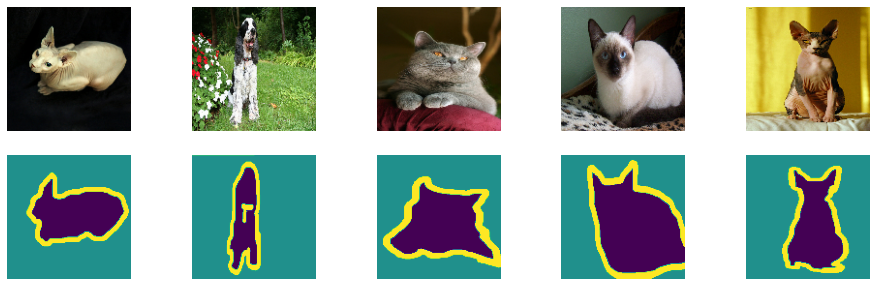

In [7]:
import matplotlib.pylab as plt
import numpy as np
f, ax = plt.subplots(2, 5, figsize=(16,5))
for idx,(img, mask) in enumerate(train.take(5)):
    ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[0, idx].axis('off')
    mask = tf.reshape(mask, [128, 128])
    ax[1, idx].imshow(mask.numpy())
    ax[1, idx].axis('off')

## U-Net
ここで使用するモデルは、[U-Net](https://link.springer.com/content/pdf/10.1007%2F978-3-319-24574-4_28.pdf)に変更を加えたものです。  
U-Netは通常、画像をエンコードにダウンサンプリングするエンコーダーと、エンコードを目的のマスクにアップサンプリングするデコーダーで構成されます。デコーダーブロックには、エンコーダーブロックをデコーダーに直接接続するいくつかのスキップ接続があります。  

最初からトレーニングを行うには、多くのトレーニング可能なパラメーターが必要であり、第12章で説明されている生成的敵対的ネットワーク(GAN)を使用する方が適切です。  

このノートブックでは、事前にトレーニングされたMobileNetV2を使用してエンコーディングを作成し、アップサンプリングレイヤーのセットを使用して目的のマスクのサイズに戻します。  
ただし、そうする場合は、必要なサイズのレイヤーを取得し、アップサンプリングスキップレイヤーがトレーニング済みモデルと対応する重みを使用するようにする必要があります。

データセットを最大限利用するために、学習用データセットでは画像を反転させてデータ拡張を行います。
(データ拡張については第6章で説明します)  

出力は3つのチャネルで構成されていることに注意してください。これは、ピクセルごとに3つのラベル(背景、輪郭、内部)があるためです。3つの可能なクラスを持つ複数分類の問題と考えてください。


In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask

train_dataset = train.cache().map(augment).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers to form skip connections
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,
                            name='pretrained_mobilenet')

down_stack.trainable = False

デコーダーは一連のアップサンプルブロックで構成されます。

Conv2DTranspose層でアップサンプリングを行い、バッチ正規化とreluを追加します。

In [15]:
def upsample(filters, size, name):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ], name=name)

up_stack = [
    upsample(512, 3, 'upsample_4x4_to_8x8'),
    upsample(256, 3, 'upsample_8x8_to_16x16'),
    upsample(128, 3, 'upsample_16x16_to_32x32'),
    upsample(64, 3,  'upsample_32x32_to_64x64')
]

In [16]:
import re

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for idx, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        concat = tf.keras.layers.Concatenate(name='expand_{}'.format(idx))
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

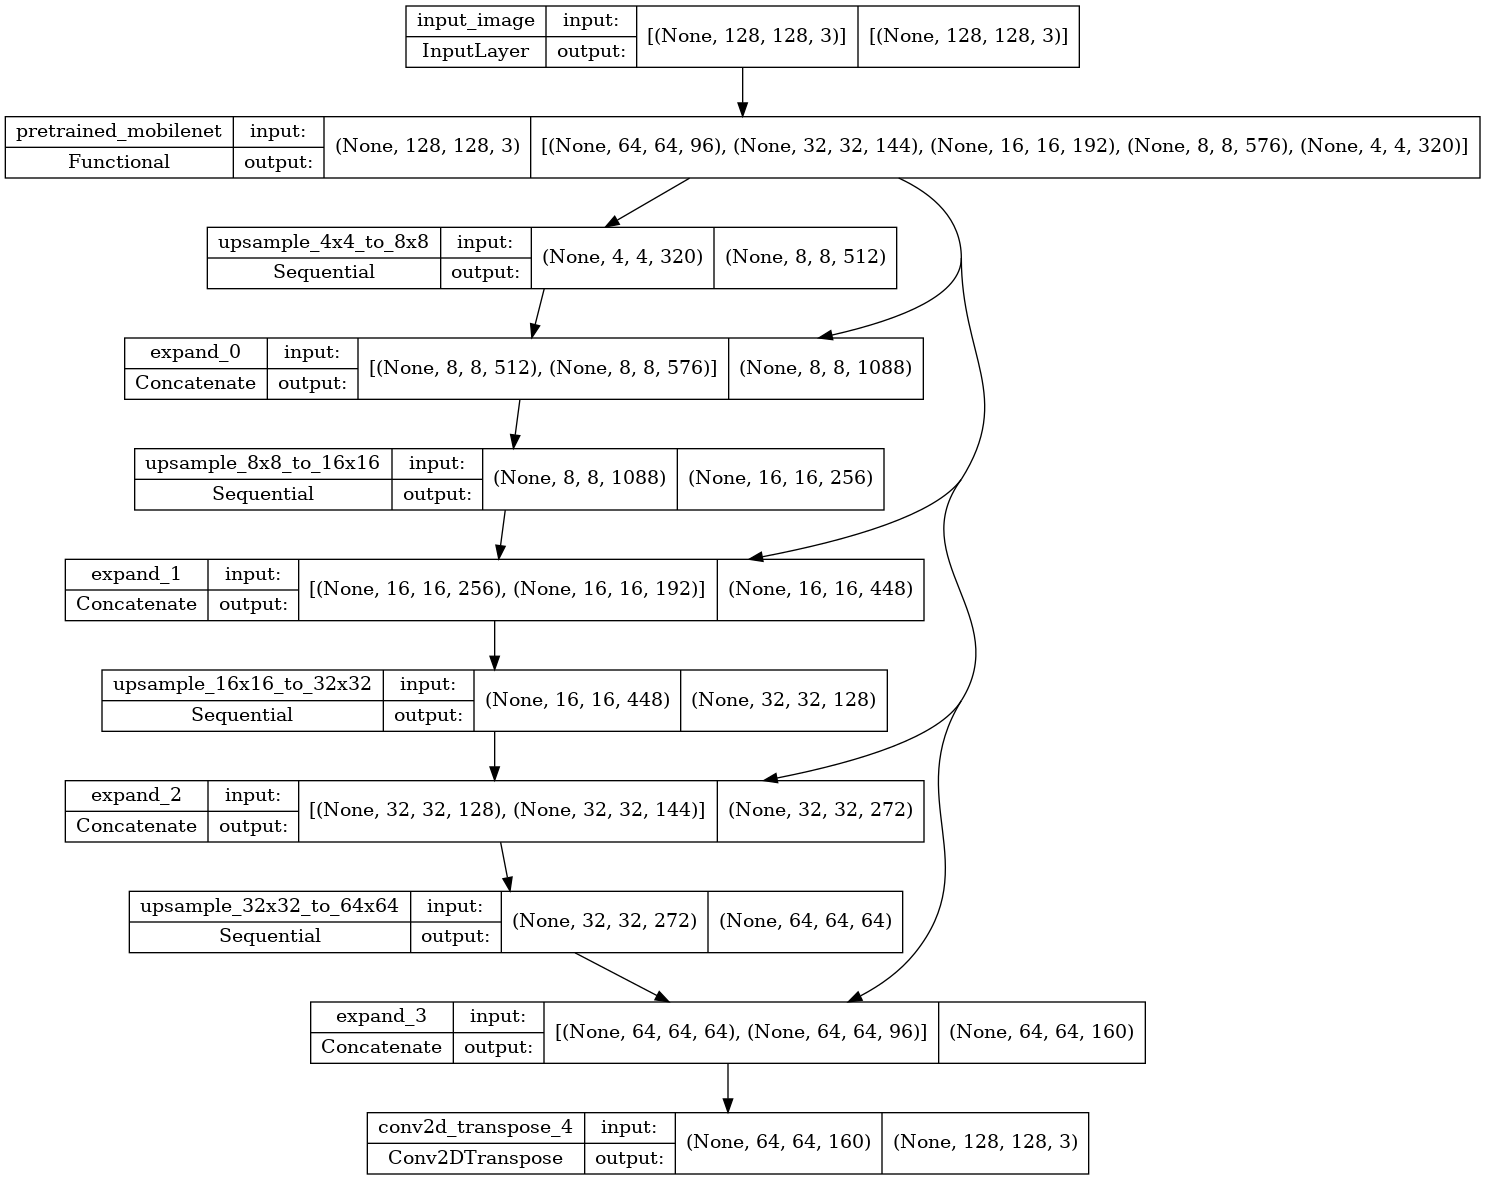

In [17]:
model = unet_model(OUTPUT_CHANNELS)
tf.keras.utils.plot_model(model, show_shapes=True)

## モデルの学習

マルチクラス予測問題として扱います。  
したがって、損失関数には`SparseCategoricalCrossentropy`、評価指標には`accuracy`を利用します。

In [18]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# Assign to the pixel the label with the highest probability
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

学習中にモデル出力を確認するヘルパー関数

In [20]:
# display helper functions
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(dataset, num):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

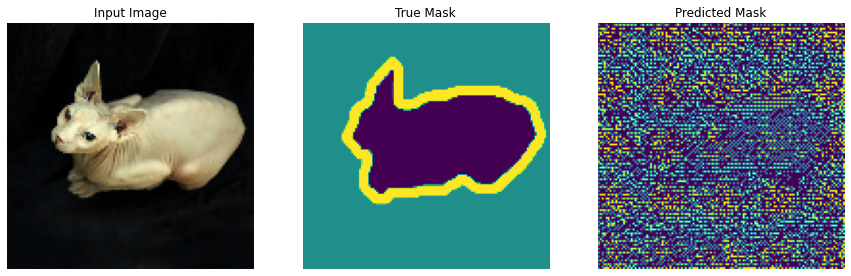

2022-05-14 09:11:00.784974: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 2124, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652519460.784855357","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 2124, Output num: 0","grpc_status":3}


In [21]:
# before the model is trained
show_predictions(train.batch(1), 1)

学習中にモデルがどのように改善されるかを観察するために、エポックが終了したときに予測を表示するコールバック関数を定義し、5エポック毎に出力します。

In [22]:
# from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%5 == 0:
          # clear_output(wait=True) # if you want replace the images each time, uncomment this
            show_predictions(train.batch(1), 1)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
 6/57 [==>...........................] - ETA: 19s - loss: 1.1212 - accuracy: 0.4912WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.5406s). Check your callbacks.


57/57 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.6772

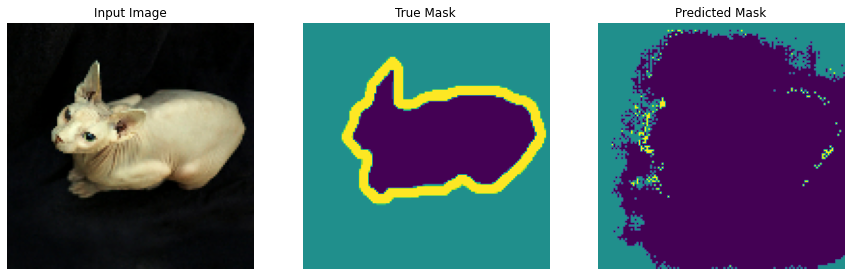


Sample Prediction after epoch 1

57/57 [==============================] - 31s 472ms/step - loss: 0.7557 - accuracy: 0.6772 - val_loss: 2.1533 - val_accuracy: 0.4680
Epoch 2/20
57/57 [==============================] - 24s 422ms/step - loss: 0.6092 - accuracy: 0.7440 - val_loss: 0.8440 - val_accuracy: 0.6427
Epoch 3/20
57/57 [==============================] - 24s 419ms/step - loss: 0.5878 - accuracy: 0.7531 - val_loss: 0.6208 - val_accuracy: 0.7392
Epoch 4/20
57/57 [==============================] - 24s 419ms/step - loss: 0.5755 - accuracy: 0.7585 - val_loss: 0.5927 - val_accuracy: 0.7525
Epoch 5/20
57/57 [==============================] - 24s 420ms/step - loss: 0.5609 - accuracy: 0.7658 - val_loss: 0.5704 - val_accuracy: 0.7614
Epoch 6/20
57/57 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.7695

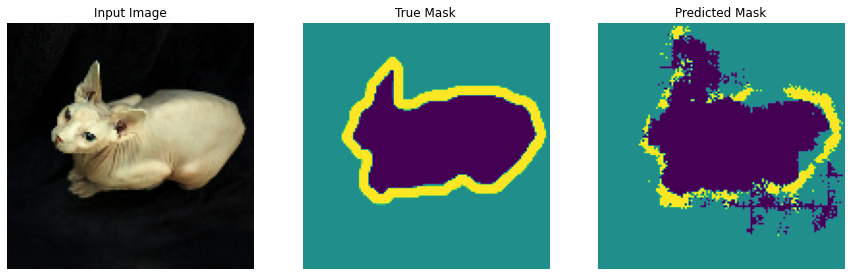


Sample Prediction after epoch 6

57/57 [==============================] - 24s 428ms/step - loss: 0.5497 - accuracy: 0.7695 - val_loss: 0.5687 - val_accuracy: 0.7609
Epoch 7/20


2022-05-14 09:13:37.759760: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 4953, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652519617.759688948","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4953, Output num: 1","grpc_status":3}


57/57 [==============================] - 24s 418ms/step - loss: 0.5510 - accuracy: 0.7696 - val_loss: 0.5679 - val_accuracy: 0.7604
Epoch 8/20
57/57 [==============================] - 24s 420ms/step - loss: 0.5380 - accuracy: 0.7748 - val_loss: 0.5626 - val_accuracy: 0.7664
Epoch 9/20
57/57 [==============================] - 24s 420ms/step - loss: 0.5340 - accuracy: 0.7775 - val_loss: 0.5477 - val_accuracy: 0.7708
Epoch 10/20
57/57 [==============================] - 24s 420ms/step - loss: 0.5262 - accuracy: 0.7805 - val_loss: 0.5571 - val_accuracy: 0.7648
Epoch 11/20
57/57 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7804

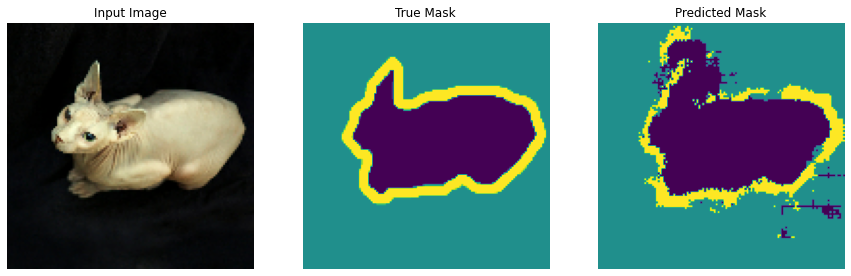


Sample Prediction after epoch 11

57/57 [==============================] - 24s 425ms/step - loss: 0.5254 - accuracy: 0.7804 - val_loss: 0.5448 - val_accuracy: 0.7730
Epoch 12/20


2022-05-14 09:15:37.604417: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 7114, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652519737.604326919","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 7114, Output num: 1","grpc_status":3}


57/57 [==============================] - 24s 420ms/step - loss: 0.5297 - accuracy: 0.7786 - val_loss: 0.5493 - val_accuracy: 0.7705
Epoch 13/20
57/57 [==============================] - 24s 421ms/step - loss: 0.5145 - accuracy: 0.7852 - val_loss: 0.5400 - val_accuracy: 0.7744
Epoch 14/20
57/57 [==============================] - 24s 423ms/step - loss: 0.5123 - accuracy: 0.7861 - val_loss: 0.5474 - val_accuracy: 0.7708
Epoch 15/20
57/57 [==============================] - 24s 419ms/step - loss: 0.5075 - accuracy: 0.7881 - val_loss: 0.5471 - val_accuracy: 0.7708
Epoch 16/20
57/57 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7888

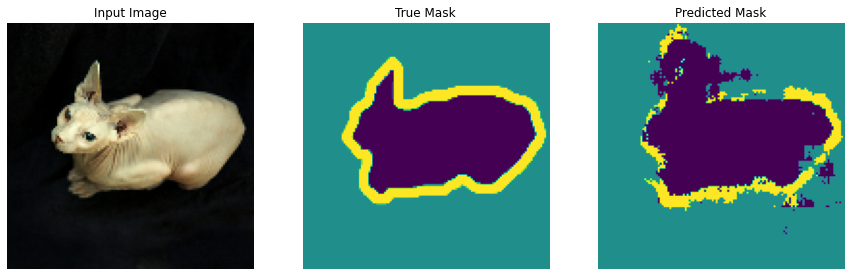


Sample Prediction after epoch 16

57/57 [==============================] - 24s 428ms/step - loss: 0.5068 - accuracy: 0.7888 - val_loss: 0.5535 - val_accuracy: 0.7723
Epoch 17/20


2022-05-14 09:17:37.877209: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 9275, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652519857.877103323","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 9275, Output num: 1","grpc_status":3}


57/57 [==============================] - 24s 421ms/step - loss: 0.5009 - accuracy: 0.7901 - val_loss: 0.5383 - val_accuracy: 0.7776
Epoch 18/20
57/57 [==============================] - 24s 419ms/step - loss: 0.4960 - accuracy: 0.7931 - val_loss: 0.5661 - val_accuracy: 0.7631
Epoch 19/20
57/57 [==============================] - 24s 421ms/step - loss: 0.4973 - accuracy: 0.7924 - val_loss: 0.5314 - val_accuracy: 0.7790
Epoch 20/20
57/57 [==============================] - 24s 422ms/step - loss: 0.4873 - accuracy: 0.7966 - val_loss: 0.5488 - val_accuracy: 0.7732


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

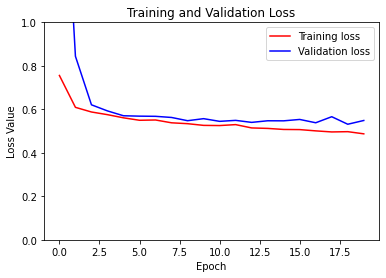

In [24]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 推論
では、テスト用データセットからいくつかの画像を推論し、マスクを作成してみましょう。

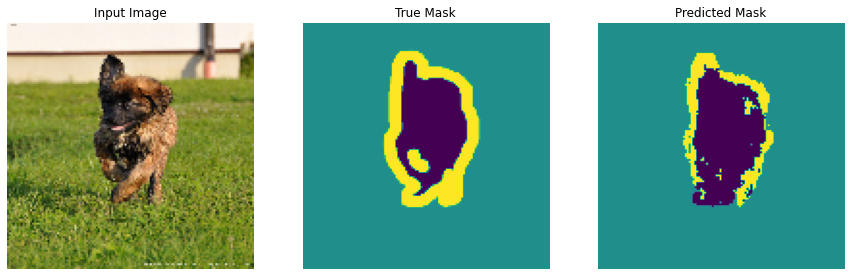

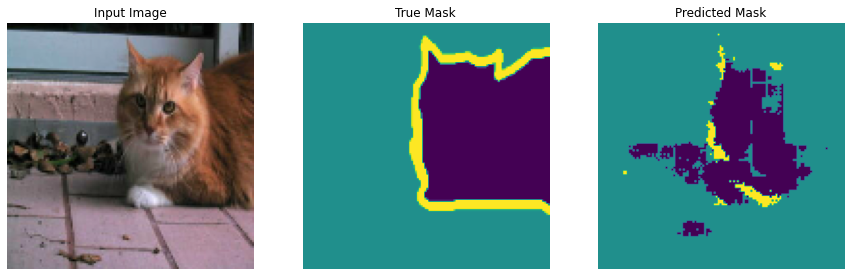

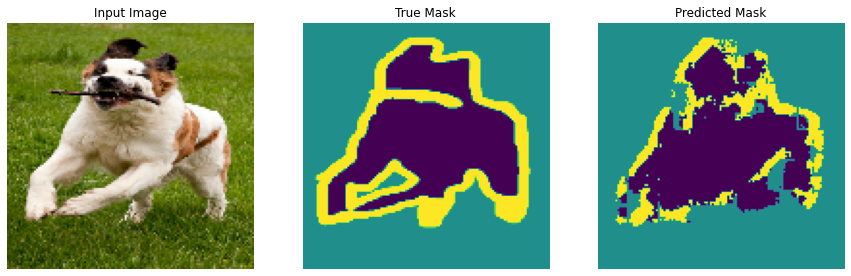

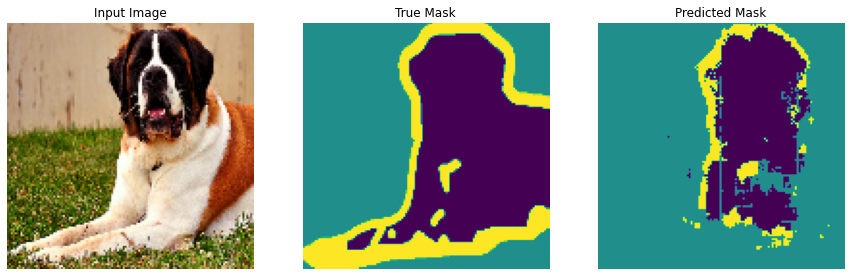

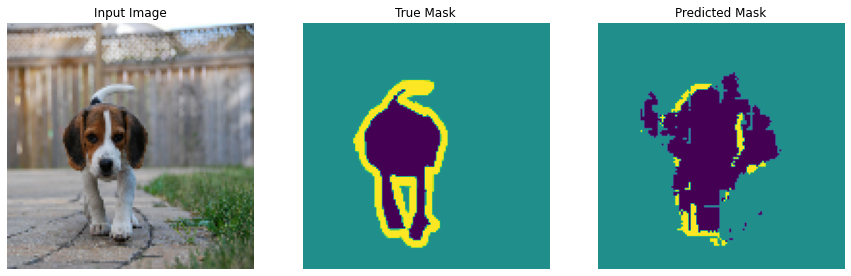

2022-05-14 09:26:24.763754: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 11233, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652520384.763602650","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 11233, Output num: 1","grpc_status":3}


In [25]:
show_predictions(test.batch(1), 5)

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook is based on https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb which is also licensed under Apache 2